In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from UsefulFunctions import *
import seaborn as sns
from config_path import MS_DATA_PATH, SEPSIS_PATH, HA_PATH
from dpks.quant_matrix import QuantMatrix


Base path: ..


In [2]:
def get_proteins_triv_name(proteins):
    human_proteome = pd.read_csv('../data/human_proteome.gz')
    human_proteome['accession'] = human_proteome['accession'].apply(lambda x: x.split('_')[0])
    names = []
    for protein in proteins:
        if protein in human_proteome['accession'].values:
            m = human_proteome.loc[human_proteome['accession'] == protein]['trivname'].values
            assert len(m) == 1
            m = m[0].split('_')[0]
        else:
            m = protein
        names.append(m)
    return names

## DPKS
---

In [5]:
import pyperclip
covid = pd.read_csv('../data/ms/covid/AaronQM.tsv', sep="\t")
s = ""
for r in covid['Protein'].values:
    s = s+r+ "\n"
pyperclip.copy(s)


(array([13402.,   193.,  1028.,  5629., 12670.,  8850.,  3793.,  2415.,
          614.,    19.]),
 array([ 0.       ,  1.2064333,  2.4128666,  3.6192999,  4.8257332,
         6.0321665,  7.2385998,  8.4450331,  9.6514664, 10.8578997,
        12.064333 ]),
 <BarContainer object of 10 artists>)

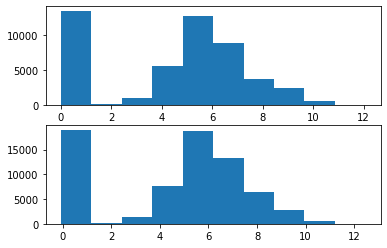

In [3]:
#COVID

quant_matrix = QuantMatrix(
    quantification_file=f"../data/ms/covid/Aaron_data_cropped.tsv",
    design_matrix_file=f"../data/ms/covid/design_cropped.tsv"
)

qm = quant_matrix.normalize(method="mean").quantify(method='maxlfq', threads=12)
fig, ax = plt.subplots(2,1)
ax[1].hist(qm.to_df()[quant_matrix.get_samples(2)].fillna(0).to_numpy().flatten())
ax[0].hist(qm.to_df()[quant_matrix.get_samples(1)].fillna(0).to_numpy().flatten())

(array([1.9041e+04, 2.2300e+02, 1.4330e+03, 7.6490e+03, 1.8695e+04,
        1.3237e+04, 6.4850e+03, 2.8570e+03, 6.0600e+02, 1.2000e+01]),
 array([-0.07308531,  1.17999919,  2.43308369,  3.68616819,  4.9392527 ,
         6.1923372 ,  7.4454217 ,  8.6985062 ,  9.9515907 , 11.2046752 ,
        12.45775971]),
 <BarContainer object of 10 artists>)

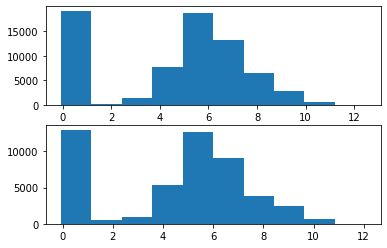

In [7]:
quant_matrix = QuantMatrix(
    quantification_file=f"../data/ms/covid/Aaron_data_cropped.tsv",
    design_matrix_file=f"../data/ms/covid/design_cropped.tsv"
)

qm = quant_matrix.normalize(method="mean").quantify(method='maxlfq', threads=12).impute(method="uniform", percentile=0.1)
fig, ax = plt.subplots(2,1)
ax[1].hist(qm.to_df()[quant_matrix.get_samples(1)].fillna(0).to_numpy().flatten())
ax[0].hist(qm.to_df()[quant_matrix.get_samples(2)].fillna(0).to_numpy().flatten())

In [8]:
compare_df = qm.compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df().dropna(subset=['CorrectedPValue'])
compare_df
compare_df['logPValue'] = compare_df['PValues1-2'].apply(lambda x: -np.log(x))
compare_df['DifferentialExpression'] = ((compare_df['logPValue']/max(compare_df['logPValue'].values))**2 
                                        + (compare_df['Log2FoldChange1-2']/max(compare_df['Log2FoldChange1-2'].values))**2)**0.5
get_proteins_triv_name(compare_df.sort_values('DifferentialExpression', ascending=False)['Protein'][0:10])

['SAA2',
 'PLF4',
 'S10A8',
 'CXCL7',
 'TSP1',
 'PIGR',
 'CRP',
 'PEDF',
 'LBP',
 'ZA2G']

   color  count
0  black    165
1   blue      3
2    red      1
Group 1: 125.38790035587189 +- 11.803359022057839 Group 2: 126.15270935960591 +- 10.537352283756169


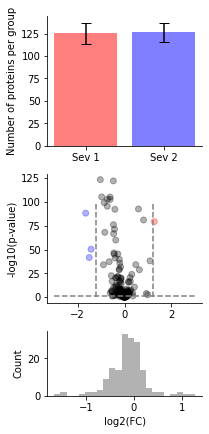

In [6]:

GroupOneCols = qm.get_samples(1)
GroupTwoCols = qm.get_samples(2)
compare_df['logPValue'] = compare_df['PValues1-2'].apply(lambda x: -np.log(x))
compare_df['color'] = compare_df.apply(lambda x: color_if_significant(x), axis=1)
compare_df['count'] = 1
print(compare_df.groupby('color', as_index=False).sum()[['color','count']])

fig, ax = plt.subplots(3,1,sharex=False, figsize = (3,6), gridspec_kw={'height_ratios': [2, 2,1]})

group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)

print(f"Group 1: {group1_mean} +- {group1_sd} Group 2: {group2_mean} +- {group2_sd}")


ax[1].scatter(x=compare_df['Log2FoldChange1-2'].values , y=compare_df['logPValue'].values, color=compare_df['color'].values, alpha=0.3)

ax[1].vlines(1.2, ymin=0, ymax=100, color='gray', linestyle='dashed')
ax[1].vlines(-1.2, ymin=0, ymax=100,color='gray', linestyle='dashed')
ax[1].hlines(1.31, xmin=-3, xmax=3, color='gray', linestyle='dashed')
ax[1].set_ylabel('-log10(p-value)')

g = sns.histplot(compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[2])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[2].set_ylabel('Count')
ax[2].set_xlabel('log2(FC)')



ax[0].bar(x = ['Sev 1', 'Sev 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[0].set_ylabel('Number of proteins per group')

plt.tight_layout()

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

plt.savefig('../plots/manuscript/covid_ProteinVolcanoHist.jpg', bbox_inches='tight', dpi=300)

(array([2.3827e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0000e+00,
        2.0100e+03, 1.7593e+04, 1.6862e+04, 7.0200e+03, 8.2100e+02]),
 array([ 0.        ,  2.89717211,  5.79434422,  8.69151633, 11.58868844,
        14.48586055, 17.38303266, 20.28020477, 23.17737688, 26.07454899,
        28.97172111]),
 <BarContainer object of 10 artists>)

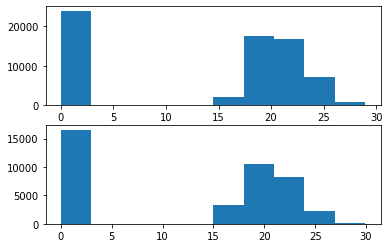

In [105]:

#SEPSIS
quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/sepsis/inner.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/sepsis/inner_design_matrix.tsv"
)

qm = quant_matrix.normalize(method="mean").quantify(method='maxlfq', threads=12)
fig, ax = plt.subplots(2,1)
ax[1].hist(qm.to_df()[quant_matrix.get_samples(1)].fillna(0).to_numpy().flatten())
ax[0].hist(qm.to_df()[quant_matrix.get_samples(2)].fillna(0).to_numpy().flatten())


(array([12262., 12155.,  5325., 10422.,  9663.,  8892.,  5564.,  2850.,
          863.,   146.]),
 array([13.59386085, 15.13164687, 16.6694329 , 18.20721893, 19.74500495,
        21.28279098, 22.820577  , 24.35836303, 25.89614905, 27.43393508,
        28.97172111]),
 <BarContainer object of 10 artists>)

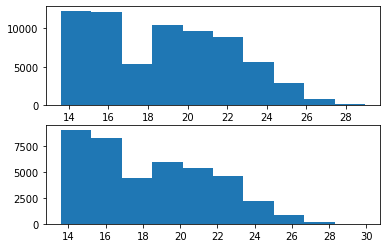

In [106]:
quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/sepsis/inner.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/sepsis/inner_design_matrix.tsv"
)
qm = quant_matrix.normalize(method="mean").quantify(method='maxlfq', threads=12).impute(method="uniform", percentile=0.1)

fig, ax = plt.subplots(2,1)
ax[1].hist(qm.to_df()[quant_matrix.get_samples(1)].fillna(0).to_numpy().flatten())
ax[0].hist(qm.to_df()[quant_matrix.get_samples(2)].fillna(0).to_numpy().flatten())



In [107]:
compare_df = qm.compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df().dropna(subset=['CorrectedPValue'])

compare_df['logPValue'] = compare_df['PValues1-2'].apply(lambda x: -np.log(x))
compare_df['DifferentialExpression'] = ((compare_df['logPValue']/max(compare_df['logPValue'].values))**2 
                                        + (compare_df['Log2FoldChange1-2']/max(compare_df['Log2FoldChange1-2'].values))**2)**0.5
get_proteins_triv_name(compare_df.sort_values('DifferentialExpression', ascending=False)['Protein'][0:10])

['BTBDI',
 'NGAL',
 'OSTP',
 'CO1A1',
 'LV743',
 'CALR',
 'MT1E',
 'DEF1',
 'P04207',
 'C163A']

   color  count
0  black    165
1   blue      3
2    red      1
Group 1: 125.38790035587189 +- 11.803359022057839 Group 2: 126.15270935960591 +- 10.537352283756169


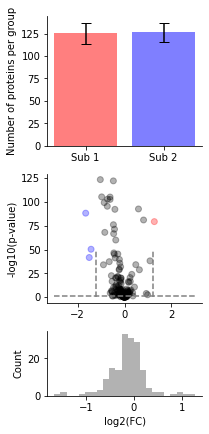

In [5]:

GroupOneCols = qm.get_samples(1)
GroupTwoCols = qm.get_samples(2)
compare_df['logPValue'] = compare_df['PValues1-2'].apply(lambda x: -np.log(x))
compare_df['color'] = compare_df.apply(lambda x: color_if_significant(x), axis=1)
compare_df['count'] = 1
print(compare_df.groupby('color', as_index=False).sum()[['color','count']])

fig, ax = plt.subplots(3,1,sharex=False, figsize = (3,6), gridspec_kw={'height_ratios': [2, 2,1]})

group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)

print(f"Group 1: {group1_mean} +- {group1_sd} Group 2: {group2_mean} +- {group2_sd}")


ax[1].scatter(x=compare_df['Log2FoldChange1-2'].values , y=compare_df['logPValue'].values, color=compare_df['color'].values, alpha=0.3)

ax[1].vlines(1.2, ymin=0, ymax=50, color='gray', linestyle='dashed')
ax[1].vlines(-1.2, ymin=0, ymax=50,color='gray', linestyle='dashed')
ax[1].hlines(1.31, xmin=-3, xmax=3, color='gray', linestyle='dashed')
ax[1].set_ylabel('-log10(p-value)')

g = sns.histplot(compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[2])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[2].set_ylabel('Count')
ax[2].set_xlabel('log2(FC)')



ax[0].bar(x = ['Sub 1', 'Sub 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[0].set_ylabel('Number of proteins per group')

plt.tight_layout()

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

plt.savefig('../plots/manuscript/sepsis_ProteinVolcanoHist.jpg', bbox_inches='tight', dpi=300)